# FlowEdit

FlowEdit: Inversion-Free Text-Based Editing Using Pre-Trained Flow Models, Kulikov et al., 2024. [[arXiv:2412.08629](https://arxiv.org/pdf/2412.08629)]

## 1. Prepare Dataset

Define the gaussian mixture distribution as the target distribution.

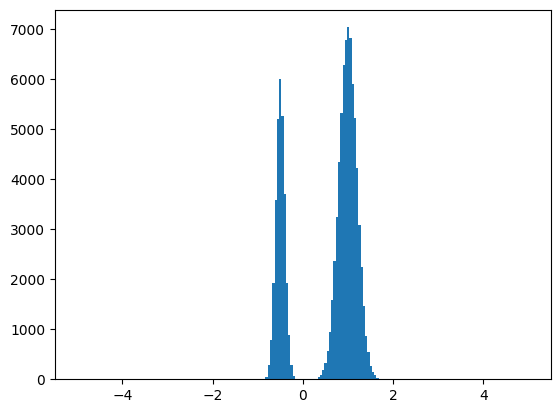

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from utils import gmm

X, Y = gmm(100000, weights=[0.3, 0.7], mean=[-0.5, 1.0], std=[0.1, 0.2])

_ = plt.hist(X, bins=np.linspace(-5, 5, 200), label="data")

## 2. Define Model

Define MLP backbone and scaled consistency training framework.

In [2]:
from flowmodels import RectifiedFlow
from utils import Backbone


model = RectifiedFlow(Backbone(aux=2))
model

RectifiedFlow(
  (velocity_estim): Backbone(
    (net): Sequential(
      (0): Linear(in_features=3, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=64, bias=True)
      (5): ReLU()
      (6): Linear(in_features=64, out_features=64, bias=True)
      (7): ReLU()
      (8): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)

## 3. Train Conditional Rectified Flows

Train the conditional rectified flows with the prepared dataset.

  0%|          | 0/1000 [00:00<?, ?it/s]

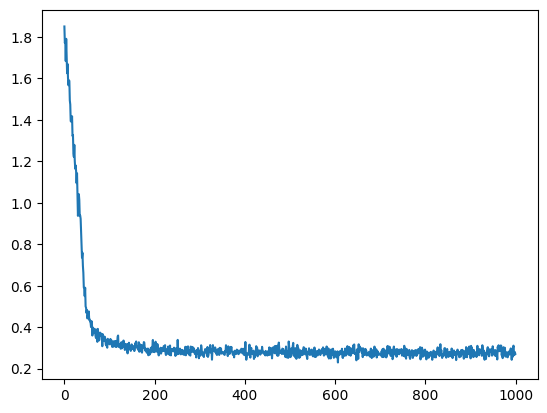

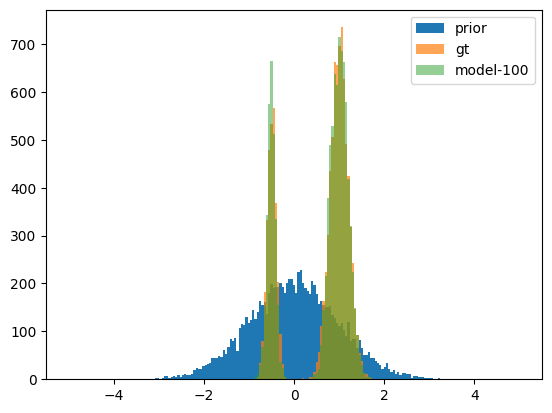

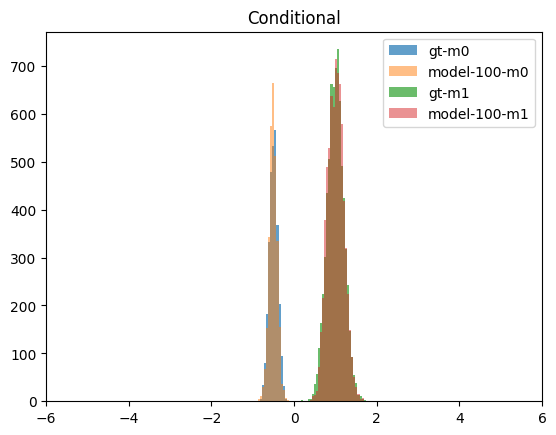

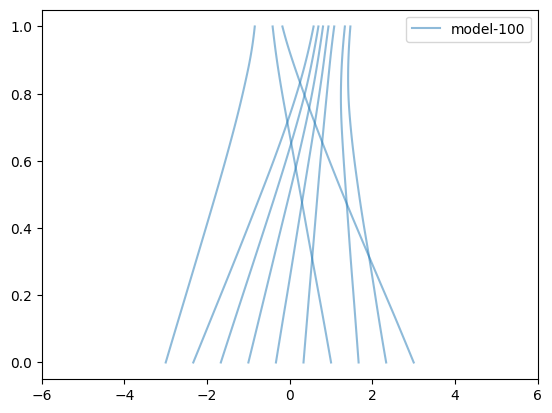

In [3]:
import torch
from tqdm.auto import tqdm

from utils import vis

# training configurations
LR = 0.001
TRAIN_STEPS = 1000
BATCH_SIZE = 2048

# train
model.train()
optim = torch.optim.Adam(model.parameters(), LR)

losses = []
with tqdm(range(TRAIN_STEPS)) as pbar:
    for i in pbar:
        indices = torch.randint(0, len(X), (BATCH_SIZE,))
        loss = model.loss(sample=X[indices], label=Y[indices])
        # update
        optim.zero_grad()
        loss.backward()
        optim.step()

        # log
        loss = loss.detach().item()
        losses.append(loss)
        pbar.set_postfix_str(f"loss: {loss:.2f}")

plt.plot(losses)
vis(model, conditional=True, steps=[100])

## 4. Run FlowEdit

Transfer the sample from class#1 to class#2

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

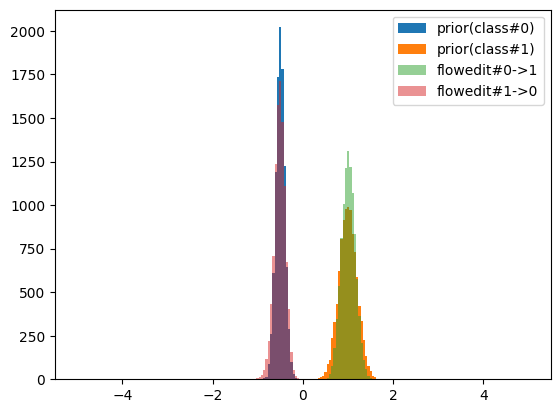

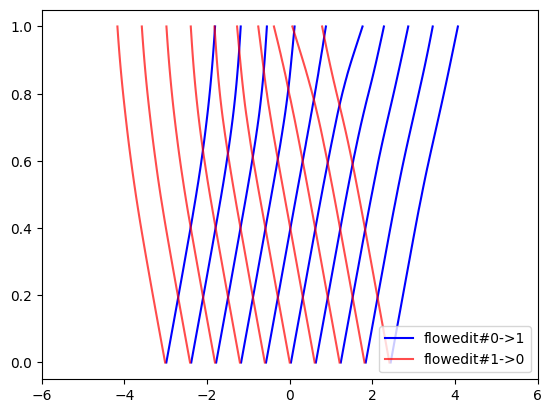

In [5]:
from flowmodels import FlowEditSolver

transport = FlowEditSolver()
with torch.inference_mode():
    x_0, _ = transport.solve(
        model,
        X[Y == 1],
        steps=100,
        verbose=lambda x: tqdm(x, leave=False),
        src=torch.ones(len(X[Y == 1])),
        tgt=torch.zeros(len(X[Y == 1])),
        n_avg=10,
    )
    x_1, _ = transport.solve(
        model,
        X[Y == 0],
        steps=100,
        verbose=lambda x: tqdm(x, leave=False),
        src=torch.zeros(len(X[Y == 0])),
        tgt=torch.ones(len(X[Y == 0])),
        n_avg=10,
    )

# plot histogram
n = 10000
plt.figure()
plt.hist(X[Y == 0][:n], bins=np.linspace(-5, 5, 200), label="prior(class#0)")
plt.hist(X[Y == 1][:n], bins=np.linspace(-5, 5, 200), label="prior(class#1)")
plt.hist(
    x_1[:n].view(-1), bins=np.linspace(-5, 5, 200), label="flowedit#0->1", alpha=0.5
)
plt.hist(
    x_0[:n].view(-1), bins=np.linspace(-5, 5, 200), label="flowedit#1->0", alpha=0.5
)
plt.legend()
_xticks, _ = plt.xticks()

# plot trajectory
n = 200
with torch.inference_mode():
    _, x_0s = transport.solve(
        model,
        torch.linspace(-3, 3, n)[:, None],
        steps=100,
        verbose=lambda x: tqdm(x, leave=False),
        src=torch.ones(n),
        tgt=torch.zeros(n),
        n_avg=10,
    )
    _, x_1s = transport.solve(
        model,
        torch.linspace(-3, 3, n)[:, None],
        steps=100,
        verbose=lambda x: tqdm(x, leave=False),
        src=torch.zeros(n),
        tgt=torch.ones(n),
        n_avg=10,
    )

plt.figure()
for i in range(10):
    plt.plot(
        torch.tensor([_x_t[i * 20].item() for _x_t in x_1s]),
        np.linspace(0, 1, len(x_1s)),
        "b",
        **({} if i > 0 else {"label": "flowedit#0->1"}),  # labeling on first plot only
    )
    plt.plot(
        torch.tensor([_x_t[i * 20].item() for _x_t in x_0s]),
        np.linspace(0, 1, len(x_0s)),
        "r",
        alpha=0.7,
        **({} if i > 0 else {"label": "flowedit#1->0"}),  # labeling on first plot only
    )
    plt.xticks(_xticks)
plt.legend()